## Package imports

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow
import pickle

In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = list(stopwords.words('english'))
#stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text(df):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        df.text=df.text.apply(lambda x: str(x).replace(i,""))

    df.text=df.text.apply(lambda x: str(x).replace('-'," "))
    return df

In [4]:
#L = WordNetLemmatizer()
s = SnowballStemmer('english')

def wordPreProcess(sentence):
    return ' '.join([s.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])

In [5]:
def getTextFeatures(df, txt, max_features=5000, ngrams=(1,2), verbose=True): #, max_features=10000
    if verbose:
        print('processing: ', txt)
    vectorizer = TfidfVectorizer(stop_words=stop_words,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
    X = vectorizer.fit_transform(df[txt])
    return X, vectorizer.get_feature_names_out()

## Import FEATURE-ENGINEERED data from EDA

In [6]:
data = pd.read_parquet('./input/dataframes/df_train_FE.parquet')
data.head(10)

,consumer_complaint_narrative,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0
5,after more than 7 years from the date of our d...,1,1,0,0.005538,0,1,0.111988,0,0.004298,0,1,0.098837,0,0,0.016295,0,0.016786,0,0,0.004106,0,0,0,1,0,0,0,1,0,0,0
6,"On XXXX XXXX 2014, a car dealership ran my cre...",1,0,1,-1.000000,1,0,0.124968,0,0.039518,0,0,-1.000000,1,0,0.062334,0,0.007891,0,1,0.001262,0,0,1,0,0,0,0,1,0,0,0
7,Received a promotional offer to deposit XXXX f...,1,0,0,-1.000000,1,0,0.012766,0,-1.000000,1,0,0.287679,0,0,0.052776,0,0.018711,0,0,0.001240,0,0,1,0,0,0,0,0,0,1,0
8,I signed up for the promotional rate of 0 % on...,1,0,0,-1.000000,1,0,0.005816,1,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.148084,0,0,0.007570,0,0,1,0,0,0,0,1,0,0,0
9,Scottrade Bank Manager XXXX XXXX XXXX instruct...,1,1,0,0.057181,0,0,0.033231,0,-1.000000,1,0,-1.000000,1,0,0.002694,1,0.148084,0,0,0.003229,0,0,1,0,0,0,1,0,0,0,0


In [7]:
# save data to df so won't have to reload data if need to start over with df.
df_train = data.copy()

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46764 entries, 0 to 46763
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   consumer_complaint_narrative           46764 non-null  object 
 1   timely_response                        46764 non-null  int32  
 2   consumer_disputed?                     46764 non-null  int32  
 3   days_between_receipt_and_sent          46764 non-null  int64  
 4   sub_product_freq                       46764 non-null  float64
 5   sub_product_null_flag                  46764 non-null  int32  
 6   sub_product_low_flag                   46764 non-null  int32  
 7   issue_freq                             46764 non-null  float64
 8   issue_low_flag                         46764 non-null  int32  
 9   sub_issue_freq                         46764 non-null  float64
 10  sub_issue_null_flag                    46764 non-null  int32  
 11  su

In [9]:
df_train.shape

(46764, 32)

In [10]:
list(df_train.columns)

['consumer_complaint_narrative',
 'timely_response',
 'consumer_disputed?',
 'days_between_receipt_and_sent',
 'sub_product_freq',
 'sub_product_null_flag',
 'sub_product_low_flag',
 'issue_freq',
 'issue_low_flag',
 'sub_issue_freq',
 'sub_issue_null_flag',
 'sub_issue_low_flag',
 'company_public_response_freq',
 'company_public_response_null_flag',
 'company_public_response_low_flag',
 'company_freq',
 'company_low_flag',
 'state_freq',
 'state_null_flag',
 'state_low_flag',
 'zipcode_freq',
 'zipcode_null_flag',
 'zipcode_low_flag',
 'Not Older American, Not Servicemember',
 'Older American',
 'Older American, Servicemember',
 'Servicemember',
 'Closed',
 'Closed with explanation',
 'Closed with monetary relief',
 'Closed with non-monetary relief',
 'Untimely response']

## Import label-encoded target

In [11]:
y_train_LE = pd.read_parquet('./input/y_targets/y_train_LE.parquet')

In [12]:
product = y_train_LE['label'].value_counts()
print(product)

4     12286
6     10443
3      8768
2      5550
0      3998
1      2575
10     1490
9       603
8       508
5       466
7        77
Name: label, dtype: int64


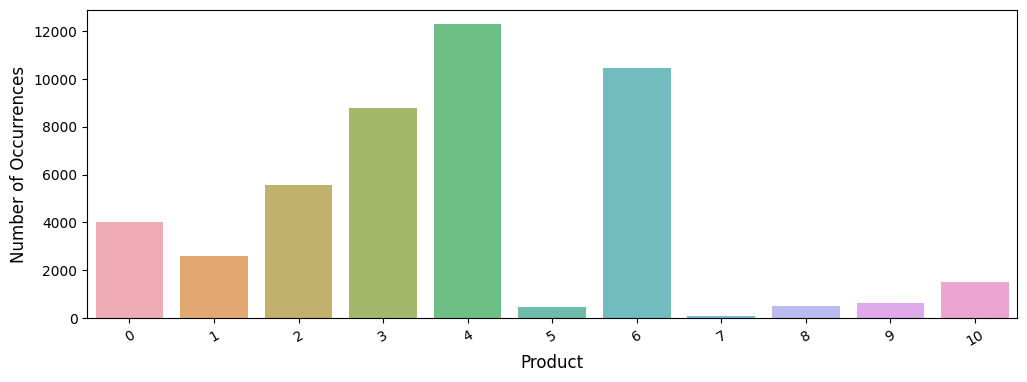

In [13]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [14]:
for i in df_train['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

Dear Sir or Madam, Ever since XXXX XXXX XXXX sold our Mortgage Loan to XXXX, we have had nothing but problems. My husband and I back in 2009, tried to modify the loan. This was an absolute nightmare. After submitting information several times and going through numerous " scheduling '' of calls with Loan counselors, who when I finally got to talk to them, had nothing of substance to discuss or help me with and offered no guidance or help. They would tell me that I needed to get certain pieces of info. and schedule yet another call ( which were always 2 weeks later ) and take it from there, then it was like XXXX XXXX XXXX ... .. I would schedule call after call just to discuss separate pieces of my Loan Mod. Application. It made NO SENSE! I got nowhere and gave up. I have a file 3 inches thick with my application, with forms and notes and all the back up info that I scanned to them, which they claimed to never have received ... .. I finally gave up. With my husband laid off due the const

In [15]:
df_train = df_train.rename({'consumer_complaint_narrative':'text'},axis=1)

In [16]:
df_train['text'] = df_train['text'].astype(str)

In [17]:
df_train.head()

,text,timely_response,consumer_disputed?,days_between_receipt_and_sent,sub_product_freq,sub_product_null_flag,sub_product_low_flag,issue_freq,issue_low_flag,sub_issue_freq,sub_issue_null_flag,sub_issue_low_flag,company_public_response_freq,company_public_response_null_flag,company_public_response_low_flag,company_freq,company_low_flag,state_freq,state_null_flag,state_low_flag,zipcode_freq,zipcode_null_flag,zipcode_low_flag,"Not Older American, Not Servicemember",Older American,"Older American, Servicemember",Servicemember,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
0,"Dear Sir or Madam, Ever since XXXX XXXX XXXX s...",1,0,0,0.098495,0,0,0.097832,0,-1.000000,1,0,-1.000000,1,0,0.020208,0,0.018711,0,0,0.001198,0,0,1,0,0,0,0,1,0,0,0
1,"on XXXX XXXX, 2015 there was an ACH transactio...",1,0,0,0.019973,0,0,0.020742,0,-1.000000,1,0,-1.000000,1,0,0.003037,1,0.089449,0,0,0.009858,0,0,1,0,0,0,0,1,0,0,0
2,My wife has not received a paper bill from Cha...,1,0,0,-1.000000,1,0,0.018283,0,-1.000000,1,0,-1.000000,1,0,0.038897,0,0.017599,0,0,0.002438,0,0,1,0,0,0,0,1,0,0,0
3,the company m & M funding has been harassing f...,1,0,6,0.005902,0,1,0.020015,0,0.002545,0,1,-1.000000,1,0,0.000021,1,0.016786,0,0,0.001711,0,0,1,0,0,0,0,1,0,0,0
4,Can my reverse mortgage lender refuse to conti...,1,0,1,0.017449,0,0,0.024741,0,-1.000000,1,0,0.055727,0,0,0.045890,0,0.003143,0,1,0.000128,0,1,0,0,0,1,0,1,0,0,0


## Sanitize and vectorize text

In [18]:
df_train = clean_text(df_train)

In [19]:
X_text_train, feat_text_train = getTextFeatures(df_train, 'text')

processing:  text


c:\Miniconda\envs\tf\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [20]:
print(X_text_train)

  (0, 1426)	0.07023567658277675
  (0, 2926)	0.09173640484268014
  (0, 2210)	0.06248056219141614
  (0, 430)	0.09494136857388034
  (0, 1526)	0.09013075933375486
  (0, 2332)	0.09147745744697006
  (0, 2975)	0.08364850181923296
  (0, 2987)	0.09141343991307281
  (0, 3757)	0.08109131827813298
  (0, 4810)	0.097330723460822
  (0, 2919)	0.09863940359674508
  (0, 4414)	0.08173018050071654
  (0, 4022)	0.08927967221802899
  (0, 4538)	0.08863317925478148
  (0, 3010)	0.07217174635809821
  (0, 4552)	0.071971011764725
  (0, 2561)	0.0922686653253795
  (0, 2979)	0.07778280710875779
  (0, 1528)	0.09917611709379352
  (0, 2973)	0.09552387706099777
  (0, 1078)	0.0997335581742154
  (0, 2346)	0.08568849412400924
  (0, 4846)	0.07831425105647367
  (0, 2269)	0.06632409634518703
  (0, 3284)	0.0578139057587166
  :	:
  (46763, 825)	0.10762964804455258
  (46763, 2889)	0.10634169244745481
  (46763, 3788)	0.08486818719081601
  (46763, 3351)	0.08299682809857142
  (46763, 2)	0.08243834047173473
  (46763, 3368)	0.11374187

In [21]:
#Saving the training text features into an NPZ file
sparse.save_npz("./input/X_matrices/X_text_train.npz", X_text_train)

## Combine text matrix with engineered features from EDA

In [22]:
# get engineered features together in place
numFeatures =['timely_response', 'consumer_disputed?', 'days_between_receipt_and_sent',
              'sub_product_freq', 'sub_product_null_flag', 'sub_product_low_flag', 'issue_freq',
              'issue_low_flag', 'sub_issue_freq','sub_issue_null_flag', 'sub_issue_low_flag',
              'company_public_response_freq', 'company_public_response_null_flag', 'company_public_response_low_flag',
              'company_freq', 'company_low_flag', 'state_freq', 'state_null_flag', 'state_low_flag',
              'zipcode_freq', 'zipcode_null_flag', 'zipcode_low_flag', 'Not Older American, Not Servicemember',
              'Older American', 'Older American, Servicemember', 'Servicemember', 'Closed', 'Closed with explanation',
              'Closed with monetary relief', 'Closed with non-monetary relief', 'Untimely response']

In [23]:
X_train = hstack((X_text_train, StandardScaler().fit_transform(df_train[numFeatures]))).tocsr()

In [24]:
#Saving the combined features into an NPZ file
sparse.save_npz("./input/X_matrices/X_train.npz", X_train)

In [25]:
y_train = y_train_LE['label'].values
print(X_train.shape)
print(y_train.shape)

(46764, 5031)
(46764,)


## Load validation dataset for model evaluation

In [26]:
X_val = sparse.load_npz("./input/X_matrices/X_val.npz")

In [27]:
y_val_LE = pd.read_parquet("./input/y_targets/y_val_LE.parquet")

In [28]:
y_val = y_val_LE['label'].values

## Baseline Classification Model with Logistic Regression

In [29]:
# Baseline label classifier with logistic regression - minimal params

log_base = LogisticRegression(
    max_iter=10000,
    random_state=2022
)

log_base.fit(X_train, y_train)

y_pred = log_base.predict(X_val)
print('Testing accuracy %s' % accuracy_score(y_val, y_pred))
print('Testing f1 score %s' % f1_score(y_val, y_pred, average='weighted'))
cm_log_base = confusion_matrix(y_val, y_pred)
cr_log_base = pd.DataFrame(classification_report(y_val, y_pred, zero_division=1, output_dict=True)).T
cr_log_base

Testing accuracy 0.8984959726281274
Testing f1 score 0.8964376001848459


,precision,recall,f1-score,support
0,0.639235,0.641368,0.640300,1199.000000
1,0.614155,0.696891,0.652913,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.942608,0.998101,0.969561,3686.000000
5,0.553571,0.664286,0.603896,140.000000
6,0.915094,0.866901,0.890346,3133.000000
7,0.000000,0.000000,0.000000,23.000000
8,0.905325,1.000000,0.950311,153.000000
9,0.670996,0.856354,0.752427,181.000000


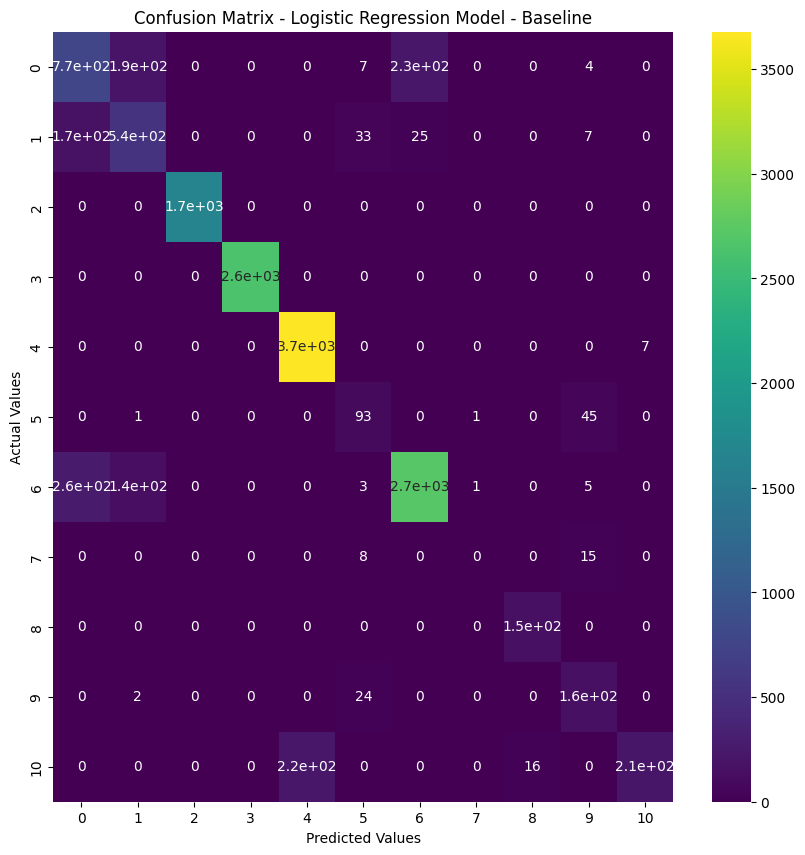

In [30]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log_base, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression Model - Baseline')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Baseline logistic regression performs well with accuracy and f1 score ~90% on the validation dataset.  This may be a difficult baseline to beat - not a bad problem to have ;)

# Try hyperparameter optimization for the logistic regression model

In [31]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver,
                            max_iter=10000, multi_class = "multinomial", random_state = 2022) #fit_intercept=fit_intercept, l1_ratio=l1_ratio, warm_start=True
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_val, log.predict(X_val))

In [32]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2023-01-06 16:28:14,515] A new study created in memory with name: Logistic Regression Classifier
[I 2023-01-06 16:28:58,436] Trial 0 finished with value: 0.8976406016109487 and parameters: {'tol': 0.0051, 'C': 0.7000000000000001, 'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.8976406016109487.
[I 2023-01-06 16:30:32,692] Trial 1 finished with value: 0.89678523059377 and parameters: {'tol': 0.0031, 'C': 0.8, 'class_weight': None, 'solver': 'saga'}. Best is trial 0 with value: 0.8976406016109487.
[I 2023-01-06 16:31:29,496] Trial 2 finished with value: 0.8960724214127878 and parameters: {'tol': 0.0021, 'C': 0.2, 'class_weight': None, 'solver': 'sag'}. Best is trial 0 with value: 0.8976406016109487.
[I 2023-01-06 16:33:36,986] Trial 3 finished with value: 0.8987810963005204 and parameters: {'tol': 0.0011, 'C': 0.8, 'class_weight': 'balanced', 'solver': 'newton-cg'}. Best is trial 3 with value: 0.8987810963005204.
[I 2023-01-06 16:35:00,129] Trial 4 finished with 

In [33]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0011, 'C': 0.8, 'class_weight': 'balanced', 'solver': 'newton-cg'}

Best Accuracy: 0.8987810963005204


In [34]:
log_clf = LogisticRegression(**log_study.best_params, max_iter=10000, multi_class = "multinomial", random_state = 2022)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_val = log_clf.predict(X_val)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_val_acc = accuracy_score(y_val, y_pred_val)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Validation Dataset: {}".format(log_val_acc))
print("\n#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Validation Dataset: {}".format(log_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_val, y_pred_val)
cr_log = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_log

Logistic Regression Accuracy on Train Dataset: 0.9837909503036524

Logistic Regression Accuracy on Validation Dataset: 0.8987810963005204

#####################

Logistic Regression F1 Score on Train Dataset: 0.9840422946776052

Logistic Regression F1 Score on Validation Dataset: 0.9035329088629656


,precision,recall,f1-score,support
0,0.634731,0.707256,0.669034,1199.000000
1,0.563315,0.783679,0.655471,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.986347,0.960391,0.973196,3686.000000
5,0.547170,0.621429,0.581940,140.000000
6,0.969225,0.814236,0.884996,3133.000000
7,0.117647,0.173913,0.140351,23.000000
8,0.900000,1.000000,0.947368,153.000000
9,0.680751,0.801105,0.736041,181.000000


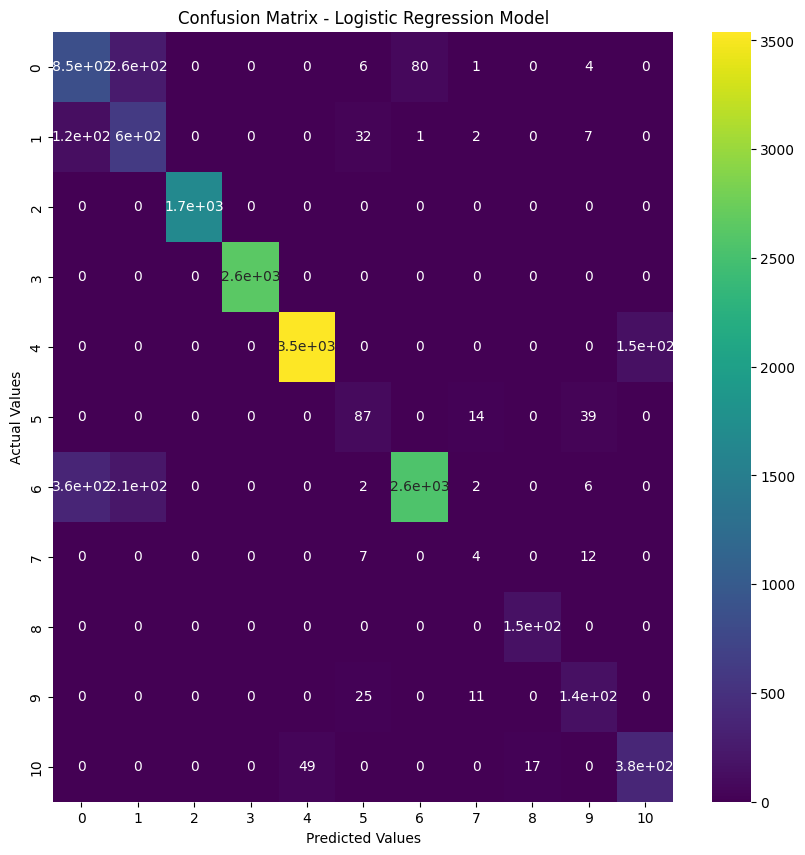

In [35]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Hyperparameter optimization with Optuna did not improve the validation accuracy and f1 score much from the logistic regression classifier baseline.
- ### Classification heatmap demonstrates fairly good classification overall. 
- ### Classifier had some confusion issues predicting Class 0 for Class 1 (bidirectionally), Class 0 or 1 for Class 6, and Class 10 for Class 4.
- ### Class 7 with least amount of support (23 samples) was only correctly predicted 4 times.
- ### Overfitting with this model is a concern since the metrics on the training data are much higher than the validation data.

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [36]:
# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, class_weight=class_weight, 
                                        max_iter=10000, random_state = 2022) 

    ## Fit Model
    pac.fit(X_train, y_train)

    return accuracy_score(y_val, pac.predict(X_val))

In [37]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2023-01-06 16:42:05,327] A new study created in memory with name: Passive Aggressive Classifier
[I 2023-01-06 16:42:06,828] Trial 0 finished with value: 0.8703400099793286 and parameters: {'C': 1.0, 'tol': 0.006, 'loss': 'hinge', 'class_weight': None}. Best is trial 0 with value: 0.8703400099793286.
[I 2023-01-06 16:42:08,768] Trial 1 finished with value: 0.8272863354480006 and parameters: {'C': 0.2, 'tol': 0.009000000000000001, 'loss': 'hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8703400099793286.
[I 2023-01-06 16:42:11,696] Trial 2 finished with value: 0.7980611590277282 and parameters: {'C': 0.9, 'tol': 0.002, 'loss': 'hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8703400099793286.
[I 2023-01-06 16:42:13,447] Trial 3 finished with value: 0.863211918169506 and parameters: {'C': 0.1, 'tol': 0.003, 'loss': 'hinge', 'class_weight': None}. Best is trial 0 with value: 0.8703400099793286.
[I 2023-01-06 16:42:15,050] Trial 4 finished with value

In [38]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.2, 'tol': 0.004, 'loss': 'squared_hinge', 'class_weight': None}

Best Accuracy: 0.8726209993584717


In [39]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params, max_iter=10000, random_state = 2022)
pac_clf.fit(X_train, y_train)

y_pred_train = pac_clf.predict(X_train)
y_pred_val = pac_clf.predict(X_val)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_val_acc = accuracy_score(y_val, y_pred_val)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Validation Dataset: {}".format(pac_val_acc))
print("\n#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Validation Dataset: {}".format(pac_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_val, y_pred_val)
cr_pac = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.9855230519202806

Passive Aggressive Classifier Accuracy on Validation Dataset: 0.8726209993584717

#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.9850200093017106

Passive Aggressive Classifier F1 Score on Validation Dataset: 0.8648870917409137


,precision,recall,f1-score,support
0,0.573296,0.512093,0.540969,1199.000000
1,0.491557,0.678756,0.570185,772.000000
2,0.999400,1.000000,0.999700,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.909181,0.996744,0.950951,3686.000000
5,0.638095,0.478571,0.546939,140.000000
6,0.916072,0.860517,0.887426,3133.000000
7,0.500000,0.086957,0.148148,23.000000
8,0.887500,0.928105,0.907348,153.000000
9,0.610687,0.883978,0.722348,181.000000


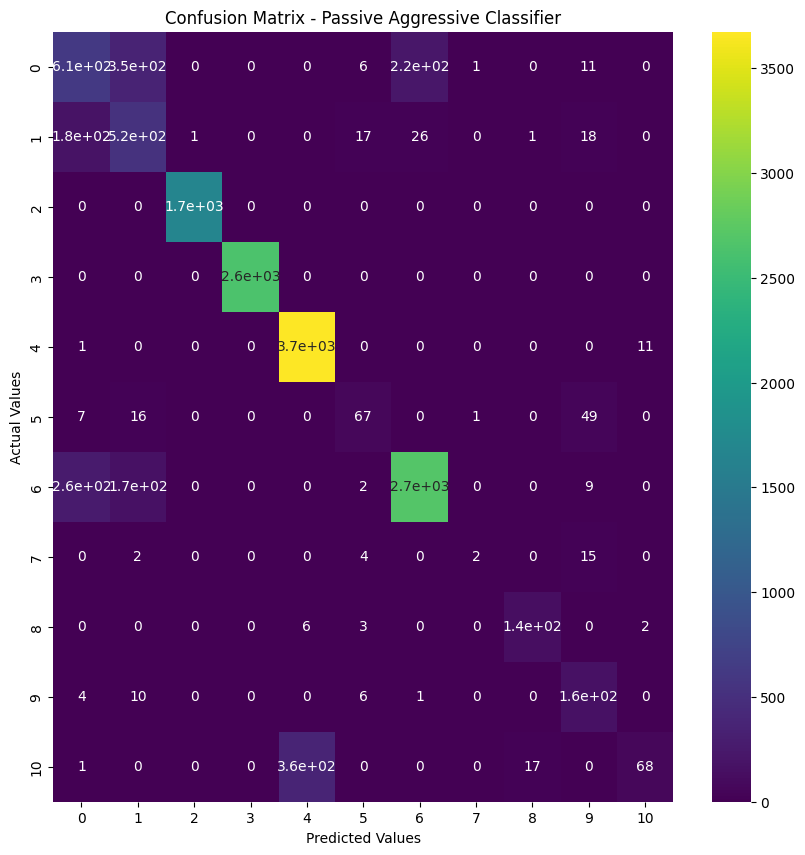

In [40]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier exhibited slightly lower validation accuracy and f1 score than the Logistic Regression Classifier.
- ### Classification heatmap demonstrates fairly good classification overall.
- ### Similar to the Logistic Regression Classifier, the Passive Aggressive Classifier had some confusion issues predicting Class 0 for Class 1 (bidirectionally), Class 0 or 1 for Class 6, Class 6 for Class 0, and Class 4 for Class 10 (inversely to the Logistic Regression Classifier). 
- ### Class 7 with least amount of support (23 samples) was only correctly predicted 2 times.
- ### Overfitting with this model is a concern since the metrics on the training data are much higher than the validation data.

## Random Forest Classifier

In [41]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, 
                                    class_weight=class_weight, random_state = 2022) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_val, rfc.predict(X_val))

In [42]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2023-01-06 16:42:26,491] A new study created in memory with name: Random Forest Classifier
[I 2023-01-06 16:42:41,718] Trial 0 finished with value: 0.5964787226459477 and parameters: {'n_estimators': 550, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 80, 'min_samples_leaf': 40, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.5964787226459477.
[I 2023-01-06 17:18:31,193] Trial 1 finished with value: 0.9689215197091738 and parameters: {'n_estimators': 350, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 80, 'min_samples_leaf': 40, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9689215197091738.
[I 2023-01-06 17:18:42,314] Trial 2 finished with value: 0.5281203221897498 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 50, 'max_features': 'log2', 'bootstrap': False, 'cla

In [43]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 350, 'criterion': 'log_loss', 'max_depth': 8, 'min_samples_split': 80, 'min_samples_leaf': 40, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}

Best Accuracy: 0.9689215197091738


In [44]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params, random_state = 2022)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_val = rfc_clf.predict(X_val)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_val_acc = accuracy_score(y_val, y_pred_val)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Validation Dataset: {}".format(rfc_val_acc))
print("\n#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Validation Dataset: {}".format(rfc_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_val, y_pred_val)
cr_rfc = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.9784877256008896

Random Forest Classifier Accuracy on Validation Dataset: 0.9689215197091738

#####################

Random Forest Classifier F1 Score on Train Dataset: 0.9790622253617366

Random Forest Classifier F1 Score on Validation Dataset: 0.9695400873001643


,precision,recall,f1-score,support
0,0.937959,0.958299,0.948020,1199.000000
1,0.763788,0.950777,0.847086,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,1.000000,1.000000,1.000000,3686.000000
5,0.716981,0.542857,0.617886,140.000000
6,1.000000,0.944462,0.971438,3133.000000
7,0.239583,1.000000,0.386555,23.000000
8,1.000000,1.000000,1.000000,153.000000
9,0.702970,0.392265,0.503546,181.000000


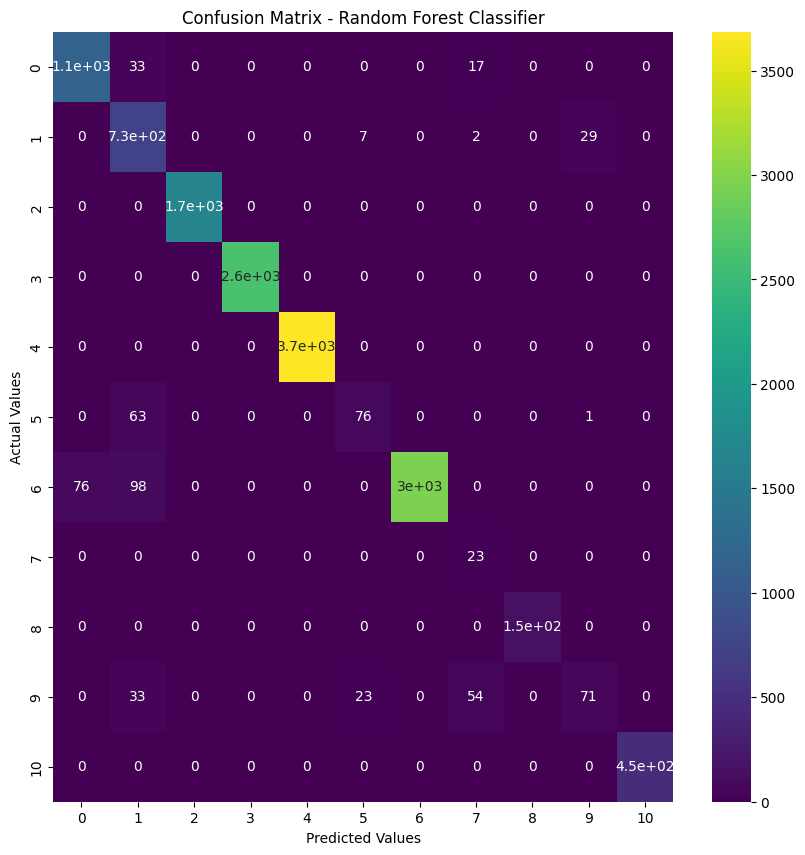

In [45]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed much better than the Logistic Regression and Passive Aggressive Classifiers with validation accuracy and f1 score, ~97%.
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### This classifier had some small confusion issues predicting Class 0 or Class 1 for Class 6, Class 1 for Class 5, and Class 7 for Class 9.
- ### Class 7 with least amount of support (23 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly for Classes 9, 0, and 1.
- ### There is very marginal evidence of small amount of overfitting with slightly higher metrics on the training data than the validation data.

## XGBoost Classifier

In [46]:
# Optimize XGBoost Classifier with optuna   ## may be better to use xgboost w/o any hyperparams/optuna to overfit and then regularize after to reduce overfit
def xgb_objective(trial):
    #booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster="gbtree", eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, eval_metric="mlogloss", use_label_encoder=False, random_state = 2022) # booster=booster, sampling_method=sampling_method,

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_val, xgb.predict(X_val))

In [47]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2023-01-06 17:56:31,952] A new study created in memory with name: XGBoost Classifier
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-06 17:57:09,619] Trial 0 finished with value: 0.9059091881103428 and parameters: {'eta': 0.6, 'gamma': 100, 'max_depth': 2, 'min_child_weight': 30, 'subsample': 0.9}. Best is trial 0 with value: 0.9059091881103428.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2023-01-06 17:58:35,983] Trial 1 finished with value: 0.9521705039560909 and parameters: {'eta': 0.5, 'gamma': 80, 'max_depth': 42, 'min_child_weight': 20, 'subsample': 0.8}. Best is trial 1 with value: 0.9521705039560909.
c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_enco

In [48]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'eta': 0.7000000000000001, 'gamma': 50, 'max_depth': 22, 'min_child_weight': 40, 'subsample': 0.6}

Best Accuracy: 0.972129161023594


In [49]:
xgb_clf = XGBClassifier(**xgb_study.best_params, booster="gbtree", use_label_encoder=False, eval_metric="mlogloss", random_state = 2022)
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_val = xgb_clf.predict(X_val)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_val_acc = accuracy_score(y_val, y_pred_val)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Validation Dataset: {}".format(xgb_val_acc))
print("\n#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Validation Dataset: {}".format(xgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_val, y_pred_val)
cr_xgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_xgb

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Classifier Accuracy on Train Dataset: 0.9927294500042768

XGBoost Classifier Accuracy on Validation Dataset: 0.972129161023594

#####################

XGBoost Classifier F1 Score on Train Dataset: 0.9919737123538324

XGBoost Classifier F1 Score on Validation Dataset: 0.9708729315220722


,precision,recall,f1-score,support
0,0.864483,0.968307,0.913454,1199.000000
1,0.938596,0.970207,0.954140,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,0.999240,1.000000,0.999620,2630.000000
4,0.986771,0.991590,0.989175,3686.000000
5,0.708333,0.728571,0.718310,140.000000
6,0.992829,0.972231,0.982422,3133.000000
7,1.000000,0.000000,0.000000,23.000000
8,0.954839,0.967320,0.961039,153.000000
9,0.764228,0.519337,0.618421,181.000000


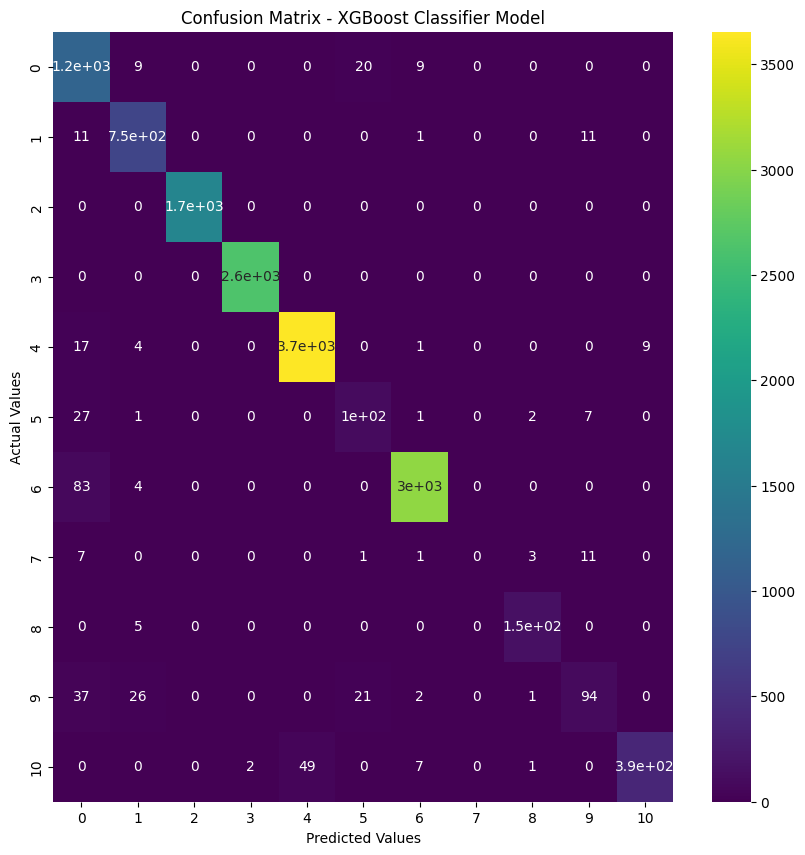

In [50]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed roughly the same as Random Forest Classifier with similar validation accuracy and f1 score, ~97%.
- ### Classification heatmap demonstrates extremely good classification overall. 
- ### This classifier had some small confusion issues predicting Class 0 for Classes 6, 9, and 5; Class 1 for Class 9; and Class 4 for Class 10.
- ### Class 7 with least amount of support (23 samples) was not correctly predicted once.  In fact, Class 7 was not predicted at all by the Classifier.
- ### There is marginal evidence of some amount of overfitting with slightly higher metrics on the training data than the validation data.

## LightGBM Classifier

In [51]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False) #decrease
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False) #decrease
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.010, step=0.001, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False) #increase
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False) #increase ## may be too high
    min_child_samples = trial.suggest_int("min_child_samples", 100, 200, step=25, log=False) #decrease  ## may be too high
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2022) #class_weight=class_weights_dict, 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_val, lgb.predict(X_val))

In [52]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2023-01-06 18:16:17,290] A new study created in memory with name: LightGBM Classifier
[I 2023-01-06 18:22:26,322] Trial 0 finished with value: 0.9434029510300093 and parameters: {'num_leaves': 4, 'max_depth': 4, 'learning_rate': 0.009000000000000001, 'n_estimators': 500, 'min_child_weight': 0.09999999999999999, 'min_child_samples': 100, 'subsample': 0.6000000000000001}. Best is trial 0 with value: 0.9434029510300093.
[I 2023-01-06 18:30:04,134] Trial 1 finished with value: 0.924299664979685 and parameters: {'num_leaves': 20, 'max_depth': 4, 'learning_rate': 0.004, 'n_estimators': 475, 'min_child_weight': 0.08, 'min_child_samples': 175, 'subsample': 1.0}. Best is trial 0 with value: 0.9434029510300093.
[I 2023-01-06 18:34:51,808] Trial 2 finished with value: 0.9414783662413572 and parameters: {'num_leaves': 4, 'max_depth': 6, 'learning_rate': 0.008, 'n_estimators': 400, 'min_child_weight': 0.02, 'min_child_samples': 125, 'subsample': 0.4}. Best is trial 0 with value: 0.94340295103000

In [53]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 4, 'max_depth': 4, 'learning_rate': 0.009000000000000001, 'n_estimators': 500, 'min_child_weight': 0.09999999999999999, 'min_child_samples': 100, 'subsample': 0.6000000000000001}

Best Accuracy: 0.9434029510300093


In [54]:
lgb_clf = LGBMClassifier(**lgb_study.best_params, boosting_type="gbdt", objective="multiclass", random_state = 2022)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_val = lgb_clf.predict(X_val)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_val_acc = accuracy_score(y_val, y_pred_val)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Validation Dataset: {}".format(lgb_val_acc))
print("\n#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Validation Dataset: {}".format(lgb_val_f1))

# Create Validation Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_val, y_pred_val)
cr_lgb = pd.DataFrame(classification_report(y_val, y_pred_val, zero_division=1, output_dict=True)).T
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 0.9995295526473356

LightGBM Classifier Accuracy on Validation Dataset: 0.9434029510300093

#####################

LightGBM Classifier F1 Score on Train Dataset: 0.9995296581555387

LightGBM Classifier F1 Score on Validation Dataset: 0.9406705712971988


,precision,recall,f1-score,support
0,0.869608,0.739783,0.799459,1199.000000
1,0.865023,0.954663,0.907635,772.000000
2,1.000000,1.000000,1.000000,1665.000000
3,1.000000,1.000000,1.000000,2630.000000
4,0.983800,0.972056,0.977893,3686.000000
5,0.723077,0.335714,0.458537,140.000000
6,0.913200,0.973827,0.942539,3133.000000
7,0.338235,1.000000,0.505495,23.000000
8,1.000000,0.607843,0.756098,153.000000
9,0.642857,0.397790,0.491468,181.000000


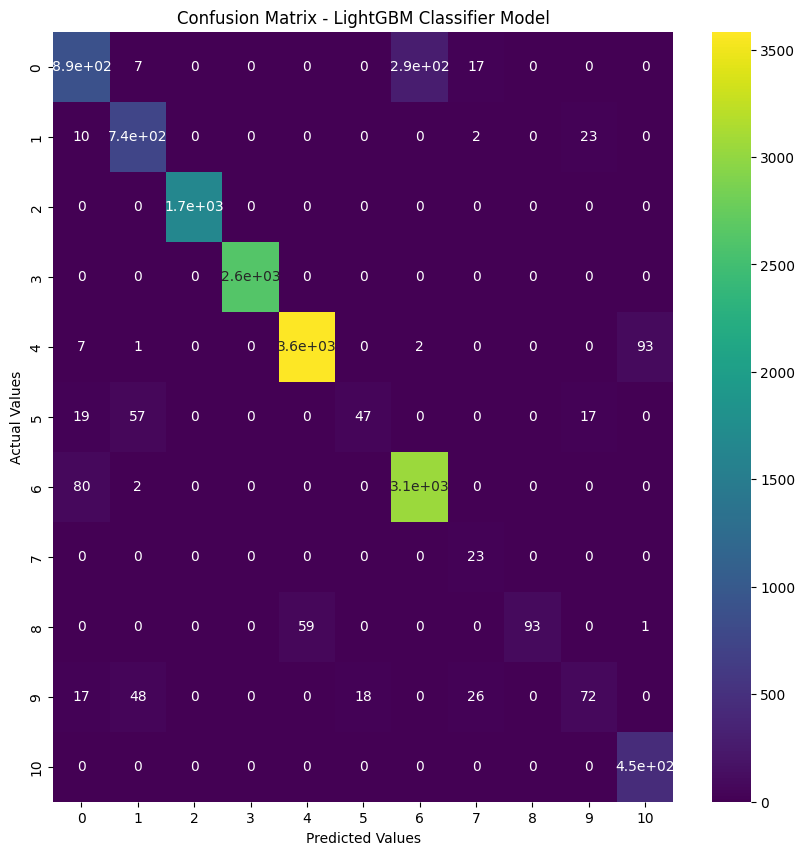

In [55]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis')
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed slightly worse than the Random Forest and XGBoost Classifiers with validation accuracy and f1 score of 94%.
- ### Classification heatmap demonstrates very good classification overall. 
- ### This classifier had a large confusion issue predicting Class 6 for Class 0. There were also some smaller issues of confusion predicting Class 0 for Class 6, Class 1 for Classes 5 and 9, Class 4 for Class 8, Class 7 for Class 9, and Class 10 for Class 4.
- ### Class 7 with least amount of support (23 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly for Classes 9, 0, and 1 (similar to the Random Forest Classifier).
- ### There is some evidence of overfitting with somewhat higher metrics on the training data than the validation data - slightly higher than Random Forest or XGBoost Classifiers.

## Save Models

In [56]:
pickle.dump(log_clf, open('./bin/tfidf/log_clf_trained.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/tfidf/pac_clf_trained.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/tfidf/rfc_clf_trained.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/tfidf/xgb_clf_trained.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/tfidf/lgb_clf_trained.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff for out-of-sample data.

In [57]:
# load 3 best saved models
rfc_clf = pickle.load(open('./bin/tfidf/rfc_clf_trained.pkl', 'rb'))
xgb_clf = pickle.load(open('./bin/tfidf/xgb_clf_trained.pkl', 'rb'))
lgb_clf = pickle.load(open('./bin/tfidf/lgb_clf_trained.pkl', 'rb'))

In [58]:
ensemble_clf = VotingClassifier(estimators=[('rfc', rfc_clf), ('xgb', xgb_clf), ('lgb', lgb_clf)], 
                                    voting='soft') # can use 'soft' argmax voting since each classifier has predict_proba

In [59]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

c:\Miniconda\envs\tf\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## Load out-of-sample test dataset and target for ensemble model evaluation

In [3]:
X_test = sparse.load_npz("./input/X_matrices/X_test.npz")

In [4]:
y_test_LE = pd.read_parquet("./input/y_targets/y_test_LE.parquet")

In [5]:
y_test = y_test_LE['label'].values

## Re-load training dataset and target for ensemble model evaluation for overfitting

In [6]:
X_train = sparse.load_npz("./input/X_matrices/X_train.npz")

In [7]:
y_train_LE = pd.read_parquet("./input/y_targets/y_train_LE.parquet")

In [8]:
y_train = y_train_LE['label'].values

# Begin ensemble model predictions and evaluation

In [9]:
# load saved ensemble model
ensemble_clf = pickle.load(open('./bin/tfidf/ensemble_clf_trained.pkl', 'rb'))

In [10]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [11]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("\n#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_ensemble = confusion_matrix(y_test, y_pred_test_ensemble)
cr_ensemble = pd.DataFrame(classification_report(y_test, y_pred_test_ensemble, zero_division=1, output_dict=True)).T
cr_ensemble

Ensemble Accuracy on Train Dataset: 0.9973483876486186

Ensemble Accuracy on Test Dataset: 0.9489439547646765

#####################

Ensemble F1 Score on Train Dataset: 0.9973789449265597

Ensemble F1 Score on Test Dataset: 0.9451177133242504


,precision,recall,f1-score,support
0,0.921456,0.935798,0.928571,514.000000
1,0.814721,0.969789,0.885517,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,0.937873,0.993671,0.964966,1580.000000
5,0.480000,0.200000,0.282353,60.000000
6,0.983759,0.947133,0.965099,1343.000000
7,0.357143,1.000000,0.526316,10.000000
8,1.000000,1.000000,1.000000,65.000000
9,0.630137,0.597403,0.613333,77.000000


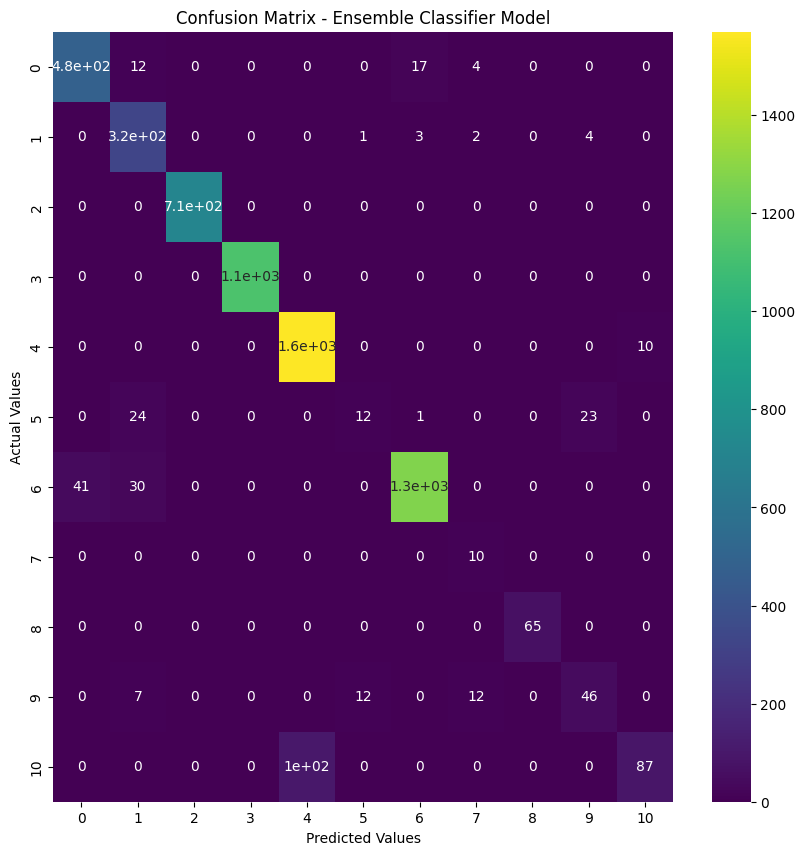

In [13]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_ensemble, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Ensemble Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Ensemble Classifier performed well with test accuracy and f1 score of 95%.
- ### Classification heatmap demonstrates very good classification overall. 
- ### This classifier had a large confusion issue predicting Class 4 for Class 10. There were also some smaller issues of confusion predicting Class 0 for Class 6, Class 1 for Classes 5 and 6, and Class 9 for Class 5.
- ### Class 7 with least amount of support (10 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly for Classes 9, 0, and 1 (similar to the Random Forest and LightGBM Classifiers).
- ### There is some evidence of overfitting with somewhat higher metrics on the training data than the test data - roughly the same amount as the LightGBM Classifier.
- ### The Random Forest Classifier appeared to have the lowest amount of overfitting and will also be evaluated on the test dataset.

## Save ensemble model

In [ ]:
pickle.dump(ensemble_clf, open('./bin/tfidf/ensemble_clf_trained.pkl', 'wb'))

## Load and compare the Random Forest Classifier performance on the test data

In [14]:
# load saved random forest classifier model
rfc_clf = pickle.load(open('./bin/tfidf/rfc_clf_trained.pkl', 'rb'))

In [15]:
y_pred_train_rfc = rfc_clf.predict(X_train)
y_pred_test_rfc = rfc_clf.predict(X_test)

In [16]:
results_rfc_train_acc = accuracy_score(y_train, y_pred_train_rfc)
results_rfc_test_acc = accuracy_score(y_test, y_pred_test_rfc)

results_rfc_train_f1 = f1_score(y_train, y_pred_train_rfc, average='weighted')
results_rfc_test_f1 = f1_score(y_test, y_pred_test_rfc, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(results_rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Test Dataset: {}".format(results_rfc_test_acc))
print("\n#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(results_rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Test Dataset: {}".format(results_rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_test, y_pred_test_rfc)
cr_rfc = pd.DataFrame(classification_report(y_test, y_pred_test_rfc, zero_division=1, output_dict=True)).T
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.9784877256008896

Random Forest Classifier Accuracy on Test Dataset: 0.9484450357558623

#####################

Random Forest Classifier F1 Score on Train Dataset: 0.9790622253617366

Random Forest Classifier F1 Score on Test Dataset: 0.9442309761570171


,precision,recall,f1-score,support
0,0.923933,0.968872,0.945869,514.000000
1,0.768116,0.960725,0.853691,331.000000
2,1.000000,1.000000,1.000000,714.000000
3,1.000000,1.000000,1.000000,1128.000000
4,0.930769,0.995570,0.962080,1580.000000
5,0.531250,0.283333,0.369565,60.000000
6,1.000000,0.940432,0.969302,1343.000000
7,0.357143,1.000000,0.526316,10.000000
8,1.000000,1.000000,1.000000,65.000000
9,0.728814,0.558442,0.632353,77.000000


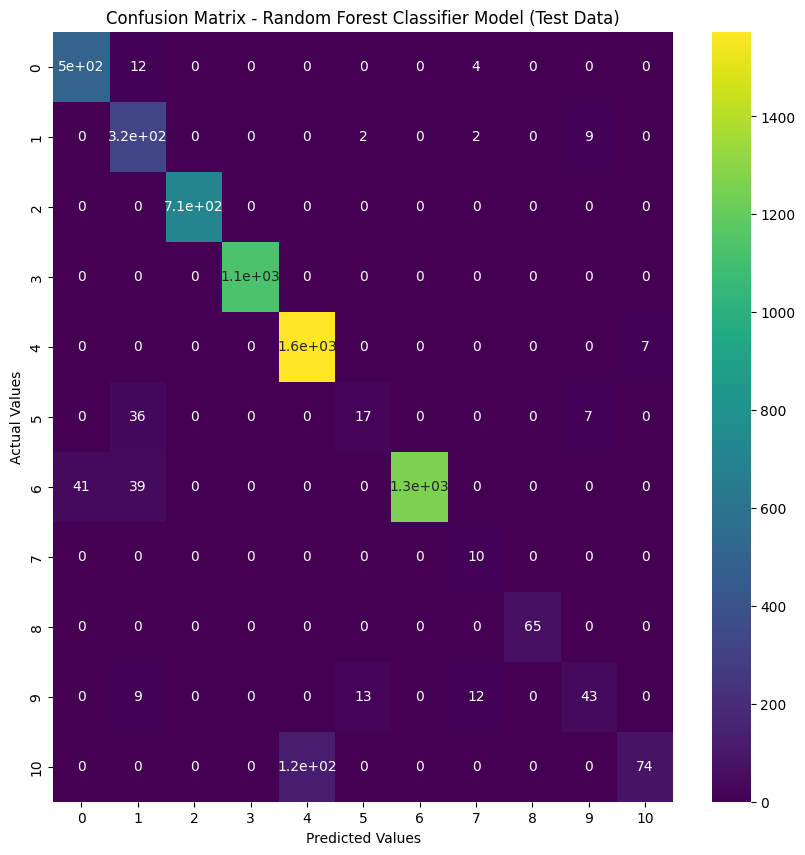

In [17]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis')
plt.title('Confusion Matrix - Random Forest Classifier Model (Test Data)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### The Random Forest Classifier performed roughly the same as the Ensemble Classifier with test accuracy and f1 score ~95/94%.
- ### Classification heatmap demonstrates very good classification overall. 
- ### Similar to the Ensemble Classifier, this classifier had a large confusion issue predicting Class 4 for Class 10. Also similar to the Ensemble Classifier, there were some smaller issues of confusion predicting Class 0 for Class 6, and Class 1 for Classes 5 and 6.
- ### Similar to the Ensemble Classifier, Class 7 with least amount of support (10 samples) was correctly predicted every time for a perfect recall score on this class.  However, Class 7 was also predicted incorrectly for Classes 9, 0, and 1 (similar to the Random Forest, LightGBM, and Ensemble Classifiers).
- ### There is some evidence of overfitting with somewhat higher metrics on the training data than the test data, however, it is not to the same degree as the Ensemble Classifier.

## Final Thoughts:
- ### Test dataset accuracy and f1 score for the Ensemble Classifier was very similar to the LightGBM Classifier's performance on the validation dataset, with associated marginal overfitting.  Further refinement would be helpful to mitigate the overfitting from the Ensemble Classifier before Model Selection.
- ### The Random Forest Classifier had comparable accuracy and f1 scores on the test datasets as the Ensemble Classifier (without the same degree of overfitting) and would be appropriate for Model Selection.
- ### Evaluation of word embeddings with Gensim's Doc2Vec follows in notebook # 02.